## Illecillewaet inversion using a corrected inventory (outlines) of the glaciers of Illecillewaet Neve

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import salem
import oggm
import os
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core import inversion
cfg.initialize(logging_level='WORKFLOW')
products_dir = '/home/pelto/Desktop/ice_thick/'
fl_smooth = 1  # Gaussian smooth of the altitude along a flowline, sigma, in pixel coordinates (sigma=1 -> smooth around a -4:+4 window)

2020-01-08 09:45:52: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


In [2]:
sh = gpd.read_file('/home/pelto/oggm_runs/OGGM-Columbia-Project/outlines/illec_divided_2016.shp') #nordic_divided_2014.shp') 

# OGGM set-up
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='illec_intersects', reset=True) #'nordic_intersects'
cfg.PARAMS['border'] = 10

divides = gpd.read_file('/home/pelto/oggm_runs/OGGM-Columbia-Project/outlines/illec_divided_2016.shp')

illec_new_shape_path = os.path.join(cfg.PATHS['working_dir'], 'illec_divided.shp')
divides.to_file(illec_new_shape_path) #template for Nordic, divides for Illec

from rgitools.funcs import compute_intersects
new_intersects = compute_intersects(divides)  #for_intersects  ##removed as no adjacent glacier at Nordic

#store our intersects to use them with OGGM afterwards
illec_intersects_path = os.path.join(cfg.PATHS['working_dir'], 'illec_divided_intersects.shp')
new_intersects.to_file(illec_intersects_path)

# This is important! We tell OGGM to recompute the glacier area for us
cfg.PARAMS['use_rgi_area'] = False
# This is the default anyway, but we set it here to be sure
cfg.PARAMS['use_intersects'] = True

cfg.PARAMS['flowline_height_smooth'] = fl_smooth

# This is important!
cfg.set_intersects_db(illec_intersects_path)
illec_intersects_path

# This is important again - standard OGGM 
rgidf = gpd.read_file(illec_new_shape_path)
rgidf

gdirs = workflow.init_glacier_regions(rgidf, reset=True, force=True)

/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
Execute entity task define_glacier_region on 5 glaciers
Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopan

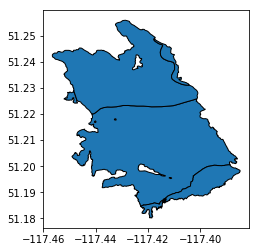

In [3]:
divides.plot(edgecolor='k');

Good! Let's use [rgitools](https://rgitools.readthedocs.io) to compute the intersects for this new situation: 

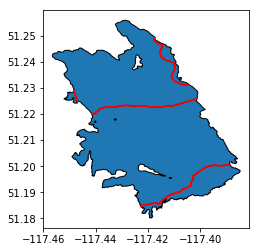

In [4]:
f, ax = plt.subplots()
divides.plot(ax=ax, edgecolor='k');  #for_intersects
new_intersects.plot(ax=ax, edgecolor='r');  

In [5]:
workflow.execute_entity_task(tasks.glacier_masks, gdirs);
workflow.execute_entity_task(tasks.compute_centerlines, gdirs);
workflow.execute_entity_task(tasks.initialize_flowlines, gdirs);
workflow.execute_entity_task(tasks.catchment_area, gdirs);
workflow.execute_entity_task(tasks.catchment_width_geom, gdirs);
workflow.execute_entity_task(tasks.catchment_width_correction, gdirs);

Execute entity task glacier_masks on 5 glaciers
Execute entity task compute_centerlines on 5 glaciers
Execute entity task initialize_flowlines on 5 glaciers
Execute entity task catchment_area on 5 glaciers
Execute entity task catchment_width_geom on 5 glaciers
Execute entity task catchment_width_correction on 5 glaciers


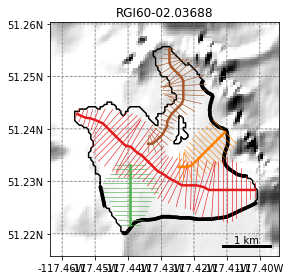

In [6]:
graphics.plot_catchment_width(gdirs[2], add_intersects=True, corrected=True);

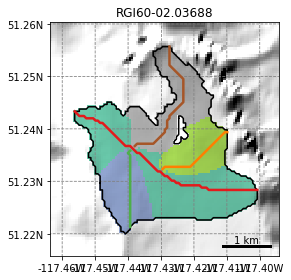

In [7]:
graphics.plot_catchment_areas(gdirs[2]);

In [8]:
gdirs[2]

<oggm.GlacierDirectory>
  RGI id: RGI60-02.03688
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 7.714 km2
  Lon, Lat: (-117.42868943174793, 51.234857214843444)
  Grid (nx, ny): (99, 101)
  Grid (dx, dy): (49.0, -49.0)

In [9]:
##inversion time
workflow.gis_prepro_tasks(gdirs)
workflow.climate_tasks(gdirs)
workflow.inversion_tasks(gdirs)
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);

Execute entity task glacier_masks on 5 glaciers
Execute entity task compute_centerlines on 5 glaciers
Execute entity task initialize_flowlines on 5 glaciers
Execute entity task compute_downstream_line on 5 glaciers
Execute entity task compute_downstream_bedshape on 5 glaciers
Execute entity task catchment_area on 5 glaciers
Execute entity task catchment_intersections on 5 glaciers
Execute entity task catchment_width_geom on 5 glaciers
Execute entity task catchment_width_correction on 5 glaciers
Execute entity task process_cru_data on 5 glaciers
Execute entity task local_t_star on 5 glaciers
Execute entity task mu_star_calibration on 5 glaciers
Execute entity task prepare_for_inversion on 5 glaciers
Execute entity task mass_conservation_inversion on 5 glaciers
Execute entity task filter_inversion_output on 5 glaciers
Execute entity task distribute_thickness_per_altitude on 5 glaciers


In [10]:
gdir = gdirs[2]
illec_new = gdir
tasks.init_present_time_glacier(gdir)

In [11]:
ds_divided = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
ds_divided.close() 

In [12]:
print(ds_divided.distributed_thickness.mean())
thickness_divided = ds_divided.distributed_thickness

<xarray.DataArray 'distributed_thickness' ()>
array(108.96847, dtype=float32)


In [13]:
mfl=gdir.read_pickle('model_flowlines')
thickness_divided = mfl[-1].surface_h - mfl[-1].bed_h
thickness_divided.mean()

89.13867201099498

In [14]:
thickness_divided[thickness_divided>0].mean()

114.88984392528242

It works!

**The intersects in OGGM are used for two main things:**
- when a grid-point glacier section touches an intersect, it will be attributed a rectangular bed (instead of a parabolic one)
- when interpolating the ice thickness to a 2D grid, the boundary condition thickness=0 at the glacier outline is removed where there are intersects



## SMB gradient

In [15]:
num = 4 #num determines which gdir and gradient to use, refer to list below to select desired site

# min to max gradients
# grad = [5.8, 9.8, 5.9, 7.95, 6.2, 5.3, 5.8] #mm we m-1
#data points gradients
grad = [6.84, 9.8, 7.11, 7.95, 10.84, 6.01, 7.92] # mm w.e. m-1

srtm = [-1.58, -6.95, -6.47, -5.71, -5.86, -6.11, 0.48]
# products_dir = '/home/pelto/Desktop/ice_thick/'
glacier = ['Kokanee', 'Haig', 'Conrad', 'W.Washmawapta', 'Illecillewaet', 'Nordic', 'Zillmer']
# gdirs

# Print the standard MB gradient from OGGM default
from oggm.core.massbalance import ConstantMassBalance, MultipleFlowlineMassBalance
# gdir = gdirs[num]

mb_mod = MultipleFlowlineMassBalance(gdir, use_inversion_flowlines=True, mb_model_class=ConstantMassBalance)
z, w, mb_on_z = mb_mod.get_annual_mb_on_flowlines()
mb_on_z *=  cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR

In [16]:
# grad_line = np.polyfit(mb_on_z,z,2)
from scipy import stats 
slope, intercept, r_value, p_value, std_err = stats.linregress(mb_on_z, z)
print("slope: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)

slope: 0.172215    intercept: 2575.022405   R-squared: 0.999189


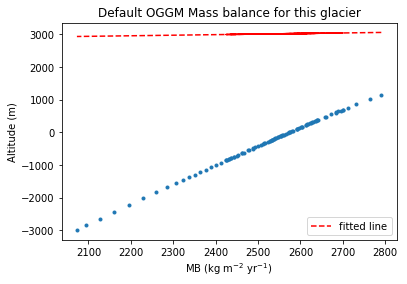

In [17]:
plt.plot(z, intercept + slope*z, 'r--', label='fitted line');
plt.plot(z, mb_on_z, '.');
plt.title('Default OGGM Mass balance for this glacier');
plt.xlabel('MB (kg m$^{-2}$ yr$^{-1}$)');
plt.ylabel('Altitude (m)');
plt.legend();

In [18]:
# See the result of the inversion
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);

Execute entity task distribute_thickness_per_altitude on 5 glaciers


In [19]:
mfl=gdir.read_pickle('model_flowlines')
thickness_default = mfl[-1].surface_h - mfl[-1].bed_h
thickness_default.mean()

89.13867201099498

In [20]:
default_thick = thickness_default[thickness_default>0].mean()
print(np.round(default_thick,2))

114.89


In [21]:
# Let's apply a linear MB instead
from oggm.core.climate import apparent_mb_from_linear_mb

# gdir = gdirs[num]
workflow.execute_entity_task(tasks.apparent_mb_from_linear_mb, gdir, mb_gradient=grad[num]);

# Compare what we got from this
from oggm.core.massbalance import LinearMassBalance

Execute entity task apparent_mb_from_linear_mb on 1 glaciers


In [22]:
params = gdir.read_pickle('linear_mb_params')
print(params)

{'ela_h': 2518.9657698709725, 'grad': 10.84}


In [23]:
l_mb_mod = LinearMassBalance(params['ela_h'], grad=params['grad'])
l_mb_on_z = l_mb_mod.get_annual_mb(z) * cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR

slope default: 5.801980    intercept: -14940.503988   R-squared: 0.999189
slope: 10.840000    intercept: -27305.588945   R-squared: 1.000000


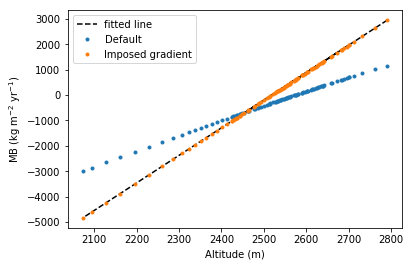

In [24]:
slope, intercept, r_value, p_value, std_err = stats.linregress(z, mb_on_z)
print("slope default: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)
slope, intercept, r_value, p_value, std_err = stats.linregress(z, l_mb_on_z)
print("slope: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)

plt.plot(z, intercept + slope*z, 'k--', label='fitted line');
plt.plot(z, mb_on_z, '.', label='Default');
plt.plot(z, l_mb_on_z, '.', label='Imposed gradient');
plt.ylabel('MB (kg m$^{-2}$ yr$^{-1}$)');
plt.xlabel('Altitude (m)');
plt.legend();

In [25]:
# Now let's recompute the inversion based on this new gradient
cfg.PARAMS['flowline_height_smooth'] = fl_smooth
workflow.inversion_tasks(gdirs)
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);
tasks.init_present_time_glacier(gdir) ##trying to update the model flowline

ds_new = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
ds_new.close() 

Execute entity task prepare_for_inversion on 5 glaciers
Multiprocessing: using all available processors (N=8)
Execute entity task mass_conservation_inversion on 5 glaciers
Execute entity task filter_inversion_output on 5 glaciers
Execute entity task distribute_thickness_per_altitude on 5 glaciers


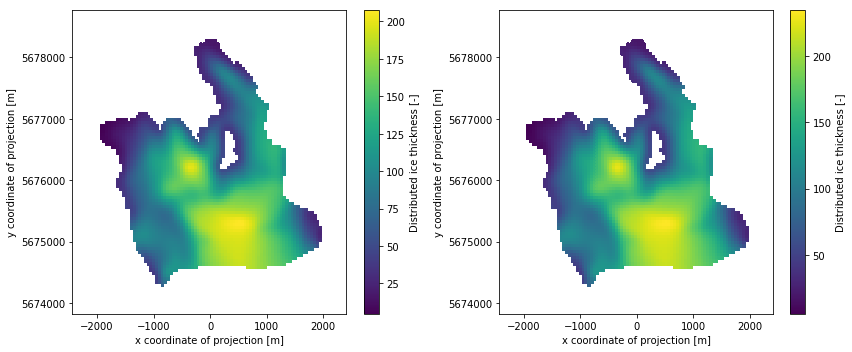

In [26]:
##side by side thickness...fine but hard to compare
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5));
ds_divided.distributed_thickness.plot(ax=ax1); #default cmap is viridis
ds_new.distributed_thickness.plot(ax=ax2);
plt.tight_layout();

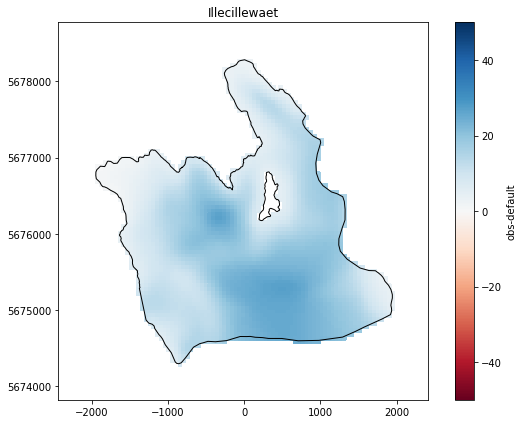

In [27]:
f, ax = plt.subplots(figsize=(8,6))
ds_new['obs-default'] = (ds_new.distributed_thickness - ds_divided.distributed_thickness)
ds_new['obs-default'].plot(ax=ax, cmap='RdBu', vmin =-50, vmax=50); #'RdBu'
plt.ylabel('')
plt.xlabel('')
plt.title(glacier[num])
gdir.read_shapefile('outlines').plot(ax=ax, color='none', edgecolor='black');
plt.tight_layout()
# plt.savefig('/home/pelto/Desktop/ice_thick/' + glacier[num] + '_mb_grad_diff.png', dpi=600)

In [28]:
print(ds_divided.distributed_thickness.mean())
print(np.mean(ds_new.distributed_thickness))

<xarray.DataArray 'distributed_thickness' ()>
array(108.96847, dtype=float32)
<xarray.DataArray 'distributed_thickness' ()>
array(123.52398, dtype=float32)


In [29]:
mfl=gdir.read_pickle('model_flowlines')
thickness_MB = mfl[-1].surface_h - mfl[-1].bed_h
thickness_MB.mean()

100.89118791201257

In [30]:
MB_thick = thickness_MB[thickness_MB>0].mean()
print(np.round(MB_thick , 2))

130.04


In [31]:
diff =  MB_thick - default_thick
print(np.round(diff, 2))

15.15


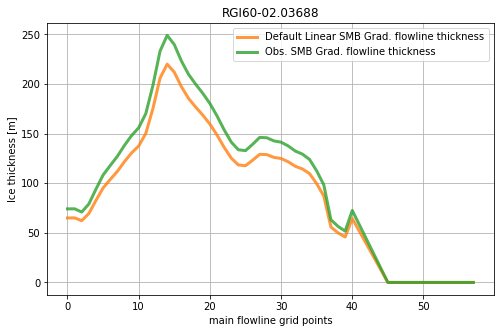

In [32]:
fig, ax = plt.subplots(figsize=[8,5])
ax.plot(thickness_default, 'C1', label='Default Linear SMB Grad. flowline thickness', linewidth=3, alpha=0.8)
ax.plot(thickness_MB, 'C2', label='Obs. SMB Grad. flowline thickness', linewidth=3, alpha=0.8)
ax.set_xlabel('main flowline grid points')
ax.set_ylabel('Ice thickness [m]')
ax.set_title(gdir.rgi_id)
ax.grid(True)
ax.legend();
# fig.savefig(products_dir + glacier[num] +'.tiff')

In [33]:
utils.compile_glacier_statistics(gdirs, inversion_only=False)

Execute entity task glacier_statistics on 5 glaciers


,rgi_region,rgi_subregion,name,cenlon,cenlat,rgi_area_km2,glacier_type,terminus_type,status,inv_volume_km3,...,flowline_mean_elev,flowline_max_elev,flowline_min_elev,flowline_avg_width,flowline_avg_slope,t_star,mu_star_glacierwide,mu_star_flowline_avg,mu_star_allsame,mb_bias
rgi_id,,,,,,,,,,,,,,,,,,,,,
RGI60-02.03684,02,02-03,,-117.449136,51.226430,0.085,Glacier,Land-terminating,Glacier or ice cap,0.003701,...,2559.176349,2577.881180,2514.235729,467.032967,0.181891,1936,180.674551,180.674551,True,321.668622
RGI60-02.03686,02,02-03,,-117.417996,51.207118,11.688,Glacier,Land-terminating,Glacier or ice cap,1.383570,...,2486.791693,2737.206595,1934.753203,1574.353448,0.151172,1937,157.197368,157.431573,False,321.134400
RGI60-02.03688,02,02-03,,-117.428689,51.234857,7.714,Glacier,Land-terminating,Glacier or ice cap,0.990581,...,2518.965770,2790.717416,2072.979342,1590.187590,0.138214,1937,166.086436,166.086436,True,321.225180
RGI60-02.03685,02,02-03,,-117.411198,51.239908,0.341,Glacier,Land-terminating,Glacier or ice cap,0.027023,...,2636.253320,2685.157917,2574.564559,357.442348,0.076300,1938,208.488147,208.488147,True,320.874434
RGI60-02.03690,02,02-03,,-117.399786,51.193068,1.414,Glacier,Land-terminating,Glacier or ice cap,0.145549,...,2538.461389,2737.608460,2289.435330,818.287037,0.131072,1937,171.913609,171.913609,True,320.810995


## Default Illecillewaet

In [34]:
WORKING_DIR = utils.gettempdir('illec_default')
utils.mkdir(WORKING_DIR, reset=True)
cfg.initialize(logging_level='WORKFLOW')
cfg.PATHS['working_dir'] = WORKING_DIR

cfg.PARAMS['border'] = 10
cfg.PARAMS['flowline_height_smooth'] = fl_smooth

2020-01-08 09:46:03: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


In [35]:
rgidf = utils.get_rgi_glacier_entities(['RGI60-02.03688'])
gdirs = workflow.init_glacier_regions(rgidf)
workflow.gis_prepro_tasks(gdirs)
workflow.climate_tasks(gdirs)
workflow.inversion_tasks(gdirs)
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);

gdir = gdirs[0]
tasks.init_present_time_glacier(gdir) ##This updates the mode_flowlines file and creates a stand-alone numerical glacier ready to run.

2020-01-08 09:46:04: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2020-01-08 09:46:04: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2020-01-08 09:46:04: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2020-01-08 09:46:04: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2020-01-08 09:46:04: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2020-01-08 09:46:04: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2020-01-08 09:46:04: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2020-01-08 09:46:04: oggm.workflo

In [36]:
ds_default = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
ds_default.close() 

In [37]:
print(ds_default.distributed_thickness.mean())
thickness_default = ds_default.distributed_thickness

<xarray.DataArray 'distributed_thickness' ()>
array(93.53087, dtype=float32)


In [38]:
mfl=gdir.read_pickle('model_flowlines')
thickness_default = mfl[-1].surface_h - mfl[-1].bed_h
thickness_default.mean()

78.49041368150627

In [39]:
thickness_default[thickness_default>0].mean()

101.57582947018459

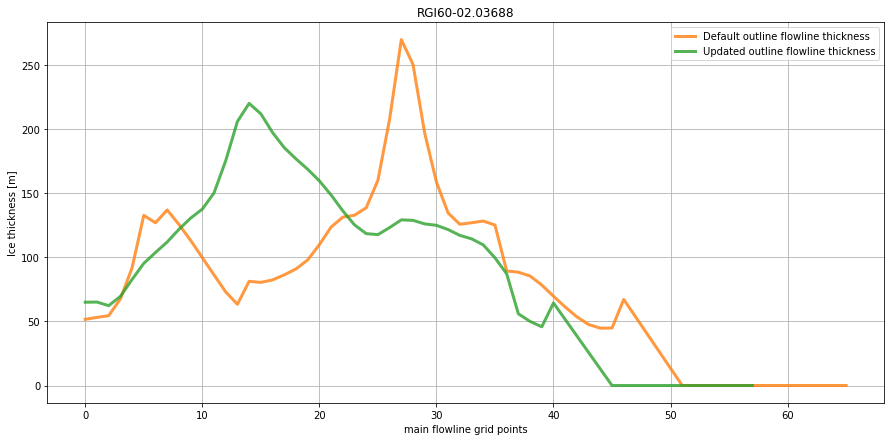

In [40]:
##hmmm off center
fig, ax = plt.subplots(figsize=[15,7])
ax.plot(thickness_default, 'C1', label='Default outline flowline thickness', linewidth=3, alpha=0.8)
ax.plot(thickness_divided, 'C2', label='Updated outline flowline thickness', linewidth=3, alpha=0.8)
ax.set_xlabel('main flowline grid points')
ax.set_ylabel('Ice thickness [m]')
ax.set_title(gdir.rgi_id)
ax.grid(True)
ax.legend();
fig.savefig(products_dir + '_illecillewaet_outline_flowline_thick.png', dpi=300)

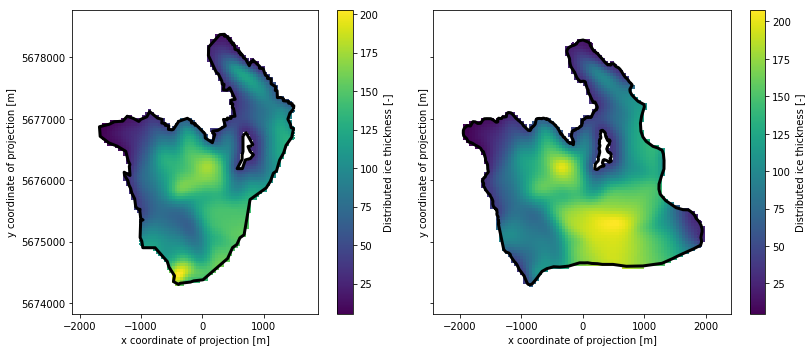

In [41]:
##side by side thickness...fine but hard to compare
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True);
ds_default.distributed_thickness.plot(ax=ax1); #default cmap is viridis
ds_divided.distributed_thickness.plot(ax=ax2);
gdir.read_shapefile('outlines').plot(ax=ax1, color='none', edgecolor='black', linewidth=3);
illec_new.read_shapefile('outlines').plot(ax=ax2, color='none', edgecolor='black', linewidth=3);
plt.tight_layout();
plt.savefig(products_dir + '_illecillewaet_side_by_side_outline_corr_thick.png', dpi=300)

In [42]:
# f, ax = plt.subplots(figsize=(8,6))
# (ds_divided - ds_default2).distributed_thickness.plot(ax=ax, cmap='RdBu', vmin =-50, vmax=50); #'RdBu'
# plt.ylabel('')
# plt.xlabel('')
# # plt.title(glacier[num])
# gdir.read_shapefile('outlines').plot(ax=ax, color='none', edgecolor='black');
# plt.tight_layout()
# # plt.savefig('/home/pelto/Desktop/ice_thick/' + glacier[num] + '_mb_grad_diff.png', dpi=600)

## GPR Data import and comparison

In [43]:
shapefile = ['2017/Kokanee_17_final_WGS84.shp', 'Haig/Haig_gpr_all_WGS84.shp', 'conrad_GPR_ALL_final_WGS84.shp', 
             'west_wash_data.shp', '2018/illec_may18_final_WGS84.shp', '2016/Nordic_2016_GPR_final_WGS84.shp', 
             'zillmer_GPR_All_final_WGS84.shp']

# '2018/illec_may18_final_WGS84_clipped.shp'
##illecillewaet radar data causes failure if using RGI polygon due to data bounds, so I clipped the radar data for now

df = salem.read_shapefile('/home/pelto/GIS/GPR/Data/' + shapefile[num])

coords = np.array([p.xy for p in df.geometry]).squeeze()
df['lon'] = coords[:, 0]
df['lat'] = coords[:, 1]
# df['lon'] = df[4]
# df['lat'] = df[5]
df = df[['lon', 'lat', 'depth']]

# Convert the longitudes and latitudes to the glacier map projection:
xx, yy = salem.transform_proj(salem.wgs84, gdir.grid.proj, df['lon'].values, df['lat'].values)
df['x'] = xx
df['y'] = yy

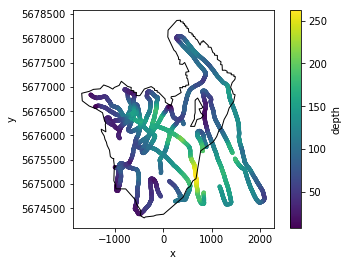

In [44]:
#plot these data
geom = gdir.read_shapefile('outlines')
f, ax = plt.subplots()
df.plot.scatter(x='x', y='y', c='depth',cmap='viridis', s=10, ax=ax); #cmap='Blues',
geom.plot(ax=ax, facecolor='none', edgecolor='k');
# illec_new.read_shapefile('outlines').plot(ax=ax, color='none', edgecolor='black', linewidth=3);

In [45]:
#The measurement points of this dataset are very frequent and close to each other. There are plenty of them:
len(df)

8171

### Aggregated per grid point

In [46]:
df_agg = df[['lon', 'lat', 'depth']].copy()
ii, jj = gdir.grid.transform(df['lon'], df['lat'], crs=salem.wgs84, nearest=True)
df_agg['i'] = ii
df_agg['j'] = jj
# We trick by creating an index of similar i's and j's
df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii, jj)]
df_agg = df_agg.groupby('ij').mean()

In [47]:
# Here, we will keep them all and interpolate the variables of interest at a the point's location. 
# We use xarray for this:
vns = ['topo',
       'slope',
       'slope_factor',
       'aspect',
       'dis_from_border',
#        'catchment_area',
#        'lin_mb_above_z',
#        'lin_mb_above_z_on_catch',
#        'oggm_mb_above_z',
#        'oggm_mb_above_z_on_catch',
       ]

In [48]:
len(df_agg)

946

In [49]:
# Select
for vn in vns:
    df_agg[vn] = ds_divided[vn].isel(x=('z', df_agg.i), y=('z', df_agg.j))

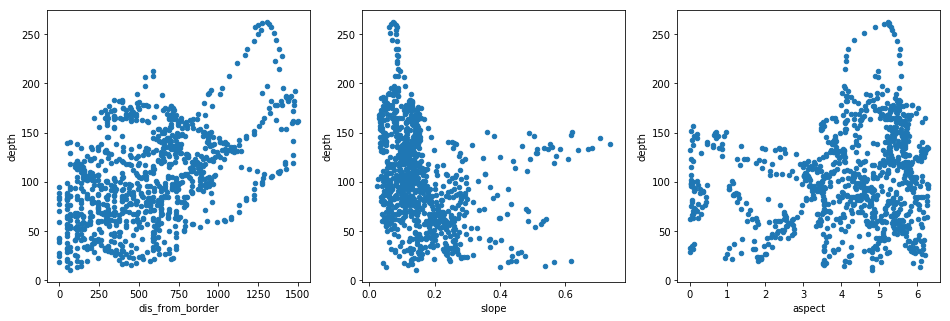

In [50]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
df_agg.plot.scatter(x='dis_from_border', y='depth', ax=ax1);
df_agg.plot.scatter(x='slope', y='depth', ax=ax2);
df_agg.plot.scatter(x='aspect', y='depth', ax=ax3);

In [51]:
# Add the linear model data for comparison
df_agg['oggm_thick'] = ds_divided.distributed_thickness.isel(x=('z', df_agg['i']), y=('z', df_agg['j']))
df_agg['obs_mb_grad_thick'] = ds_new.distributed_thickness.isel(x=('z', df_agg['i']), y=('z', df_agg['j']))

In [52]:
print(len(df_agg['depth']), len(df_agg['oggm_thick']))
print('oggm_thick divided:', np.round(np.mean(df_agg['oggm_thick']) + srtm[num],2), np.round(np.std(df_agg['oggm_thick']) + srtm[num],2))
print('obs_mb_grad_thick:', np.round(np.mean(df_agg['obs_mb_grad_thick'])+ srtm[num],2), np.round(np.std(df_agg['obs_mb_grad_thick']) + srtm[num],2))
print('GPR depth (m):', np.round(np.mean(df_agg['depth']),2), np.round(np.std(df_agg['depth']),2))

946 946
oggm_thick divided: 114.99 37.43
obs_mb_grad_thick: 131.11 43.14
GPR depth (m): 104.44 48.18


In [53]:
print('mean observed depth point:', df['depth'].mean())
print('max observed depth gridded:', df_agg['depth'].max())
print('max observed depth point:', df['depth'].max())

mean observed depth point: 104.31547179047804
max observed depth gridded: 261.7827272727273
max observed depth point: 262.02


In [54]:
df_diff = df_agg['depth'] - (df_agg['oggm_thick']) #- 1.0)
#df_diff
print('mean diff:', np.mean(df_diff))
print('med. diff:', np.nanmedian(df_diff))

mean diff: -16.470846568254615
med. diff: -18.267932250976543


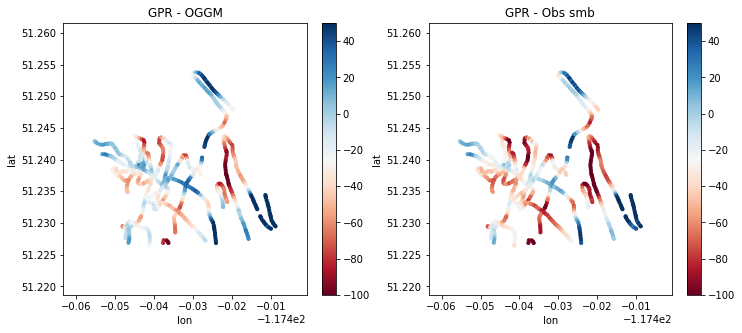

In [55]:
#GPR depth less oggm default thickness
# geom = gdir.read_shapefile('outlines')
f, (ax,ax1) = plt.subplots(1,2, figsize=(12, 5))
df_agg['GPR-oggm'] = df_agg['depth'] - df_agg['oggm_thick']
df_agg.plot.scatter(x='lon', y='lat', c=df_agg['GPR-oggm'], cmap='RdBu', s=10, ax=ax, vmax=50, vmin=-100); #cmap='Blues',
ax.title.set_text('GPR - OGGM')
# geom.plot(ax=ax, facecolor='no
#GPR depth less OGGM SMB thickness


geom = gdir.read_shapefile('outlines')
df_agg['GPR-obs_smb'] = df_agg['depth'] - df_agg['obs_mb_grad_thick']
df_agg.plot.scatter(x='lon', y='lat', c=df_agg['GPR-obs_smb'], cmap='RdBu', s=10, vmax=50, vmin=-100, ax=ax1); #cmap='Blues',
ax1.title.set_text('GPR - Obs smb')
# geom.plot(ax=ax) #facecolor='no)

In [56]:
df_agg['obs_mb_grad_thick'].max()

235.14607

In [57]:
df_agg.to_csv(products_dir + glacier[num] + '_MBgrad.csv', index=False)
ds_new.to_netcdf(products_dir + glacier[num] + '_MBgrad_gridded.nc')

In [58]:
# #plot these data
# # geom = gdir.read_shapefile('outlines')
# f, ax = plt.subplots()
# df_agg.plot.scatter(x='lon', y='lat', c=df_agg['GPR-oggm'],cmap='RdBu', s=10, ax=ax); #cmap='Blues',
# # geom.plot(ax=ax, facecolor='none', edgecolor='k');

